# Import necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline

plt.style.use('default')

# Load single cell data

In [2]:
data = pd.read_csv("temporal_data_ready_normalized.csv", index_col=0)
data = data.dropna(axis=0)

columns = data.columns

genes = np.array([name.split("_")[0] for name in list(data.index)])
cells = np.array(["_".join(name.split("_")[1:]) for name in list(data.index)])

enc_genes = LabelEncoder()
enc_cells = LabelEncoder()

enc_genes.fit(genes)
enc_cells.fit(cells)

X = data.values[:, np.newaxis, :]
y_genes = enc_genes.transform(genes)
y_cells = enc_cells.transform(cells)

X.shape, y_genes.shape, y_cells.shape, genes.shape, cells.shape

((22000, 1, 6), (22000,), (22000,), (22000,), (22000,))

## BORF

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
import numpy as np
from fast_borf import BorfBuilder
from fast_borf.pipeline.zero_columns_remover import ZeroColumnsRemover
from fast_borf.pipeline.reshaper import ReshapeTo2D
from fast_borf.pipeline.to_scipy import ToScipySparse
from fast_borf.xai.mapping import BagOfReceptiveFields
from constants import CUSTOM_CONFIG_A3, CUSTOM_CONFIG_A3_NO_DILATION, CUSTOM_CONFIG_A3_NO_DILATION_WINDOW_SIZE_2_3_4

In [4]:
# Setup the BORF builder
builder = BorfBuilder(
    n_jobs=-2, window_size_min_window_size=None, alphabets_min_symbols=None, alphabets_max_symbols=None, min_window_to_signal_std_ratio=0.15, configs=CUSTOM_CONFIG_A3_NO_DILATION_WINDOW_SIZE_2_3_4,
    pipeline_objects=[
        (ReshapeTo2D, dict(keep_unraveled_index=True)),
        (ZeroColumnsRemover, dict(axis=0)),
        (ToScipySparse, dict()),
        ],
)
borf = builder.build(X)

In [5]:
builder.configs_

[{'window_size': 2,
  'stride': 1,
  'dilation': 1,
  'word_length': 2,
  'alphabet_size': 3},
 {'window_size': 3,
  'stride': 1,
  'dilation': 1,
  'word_length': 3,
  'alphabet_size': 3},
 {'window_size': 4,
  'stride': 1,
  'dilation': 1,
  'word_length': 2,
  'alphabet_size': 3},
 {'window_size': 4,
  'stride': 1,
  'dilation': 1,
  'word_length': 4,
  'alphabet_size': 3}]

In [6]:
%%time
X_transformed = borf.fit_transform(X)
X_transformed.shape

CPU times: user 202 ms, sys: 615 ms, total: 817 ms
Wall time: 6.12 s


(22000, 74)

In [9]:
X_transformed_sorted = X_transformed.toarray()[np.argsort(cells)]
X_transformed_sorted = X_transformed_sorted[:, np.argsort(X_transformed.toarray()[np.argsort(cells)].mean(axis=0).ravel())[::-1]]
X_transformed_sorted

array([[1, 3, 1, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0],
       [2, 1, 2, ..., 0, 0, 0],
       ...,
       [1, 3, 1, ..., 0, 0, 0],
       [1, 3, 1, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0]])

In [ ]:
import lightgbm as lgb
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(lgb.LGBMClassifier(n_jobs=-1))
clf.fit(X_transformed.astype(float), y_genes)


[LightGBM] [Info] Number of positive: 11, number of negative: 21989
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.355189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 22000, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11, number of negative: 21989
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

OneVsRestClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                             n_jobs=50))

In [23]:
clf.score(X_transformed.astype(float), y_genes)

0.46140909090909094

In [12]:
np.unique(y_genes, return_counts=True)

(array([   0,    1,    2, ..., 1997, 1998, 1999]),
 array([11, 11, 11, ..., 11, 11, 11]))

In [13]:
# get all row indexes of X_transformed corresponding to one cell type
cell_type = "CIK_cells"
cell_type_indexes = np.where(enc_cells.inverse_transform(y_cells) == cell_type)[0]
cell_type_indexes

array([    6,    17,    28, ..., 21973, 21984, 21995])

In [14]:
X_transformed.toarray()[cell_type_indexes].shape

(2000, 74)

In [18]:
import fasttreeshap
shap_explainer = fasttreeshap.TreeExplainer(clf, algorithm = 'auto', n_jobs = -1)
shap_values = shap_explainer(X_transformed.toarray()[cell_type_indexes]).values

In [21]:
# Convert the specific array to a pandas DataFrame and then save it to a CSV file
shap_df_CIK_cells = pd.DataFrame(shap_values[6])
# add column names
shap_df_CIK_cells.columns = genes[cell_type_indexes].astype(str)
shap_df_CIK_cells.to_csv("shap_values_CIK_cells.csv", index=False)

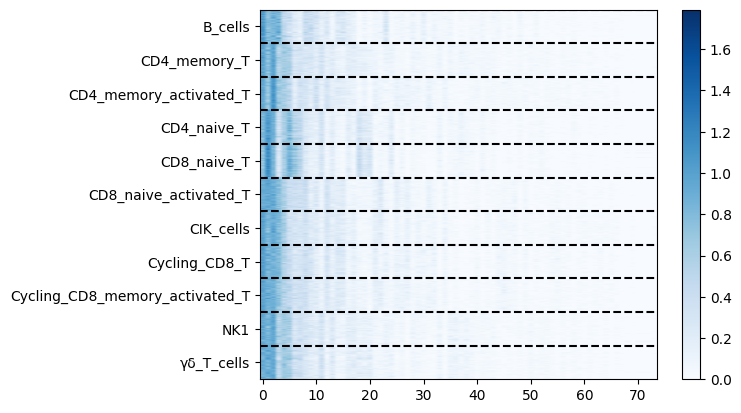

In [25]:

plt.imshow(np.log1p(X_transformed_sorted), cmap="Blues", aspect="auto")

plt.gca().set_yticks(np.arange(0, len(cells), 2000)+1000)
plt.gca().set_yticklabels(cells[np.argsort(cells)][::2000])

for i in range(0, len(cells), 2000):
    plt.axhline(y=i, color='k', linestyle='--')
plt.colorbar()

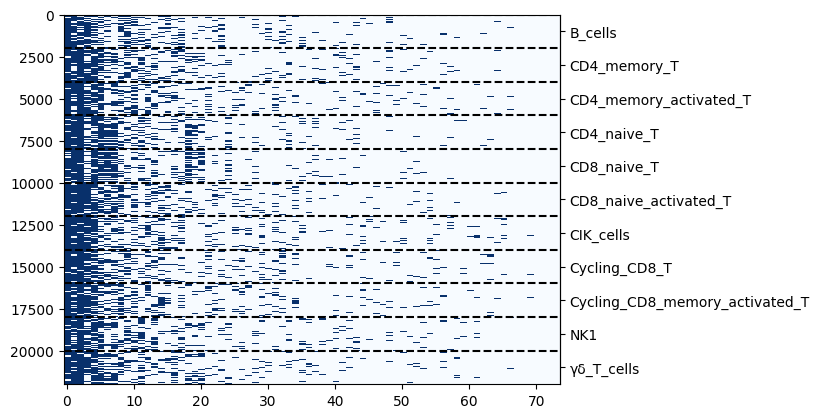

In [26]:
plt.imshow((X_transformed_sorted>0)*1, cmap="Blues", aspect="auto", interpolation="none")

# plt.axhline(y=i, color='k', linestyle='--')
secax = plt.gca().secondary_yaxis('right')  # Adds a secondary x-axis at the top
secax.set_yticks(np.arange(0, len(cells), 2000)+1000)  # Set ticks every 2000
secax.set_yticklabels(cells[np.argsort(cells)][::2000])

for i in range(0, len(cells), 2000):
    plt.axhline(y=i, color='k', linestyle='--')
# plt.xscale("log")

In [29]:
mapper = BagOfReceptiveFields(borf)
mapper.build(X)

In [31]:
mapper.mapping

array([[ 0,  0,  0],
       [ 0,  0,  2],
       [ 0,  0,  4],
       [ 0,  0,  6],
       [ 1,  0,  0],
       [ 1,  0,  2],
       [ 1,  0,  5],
       [ 1,  0,  6],
       [ 1,  0,  7],
       [ 1,  0,  8],
       [ 1,  0, 11],
       [ 1,  0, 13],
       [ 1,  0, 15],
       [ 1,  0, 18],
       [ 1,  0, 19],
       [ 1,  0, 20],
       [ 1,  0, 21],
       [ 1,  0, 24],
       [ 2,  0,  0],
       [ 2,  0,  2],
       [ 2,  0,  4],
       [ 2,  0,  6],
       [ 3,  0,  0],
       [ 3,  0,  2],
       [ 3,  0,  5],
       [ 3,  0,  6],
       [ 3,  0,  7],
       [ 3,  0,  8],
       [ 3,  0, 11],
       [ 3,  0, 14],
       [ 3,  0, 15],
       [ 3,  0, 16],
       [ 3,  0, 17],
       [ 3,  0, 18],
       [ 3,  0, 19],
       [ 3,  0, 20],
       [ 3,  0, 21],
       [ 3,  0, 22],
       [ 3,  0, 23],
       [ 3,  0, 24],
       [ 3,  0, 25],
       [ 3,  0, 26],
       [ 3,  0, 29],
       [ 3,  0, 32],
       [ 3,  0, 33],
       [ 3,  0, 34],
       [ 3,  0, 35],
       [ 3,  

[0 2] - (signal:0, window_size:2, word_length:2, dilation:1, stride:1)


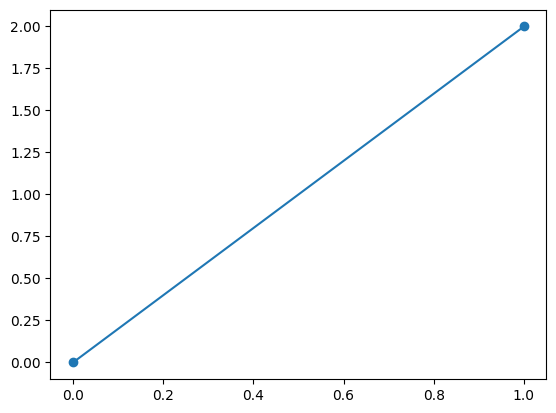

In [22]:
i = 1
print(mapper[i])
plt.plot(mapper[i].word_array, marker="o")

In [23]:
mapper[i].alignments[0]
mapper[i].mappings[0]

array([[[-0.25197296],
        [-0.01146419]]])

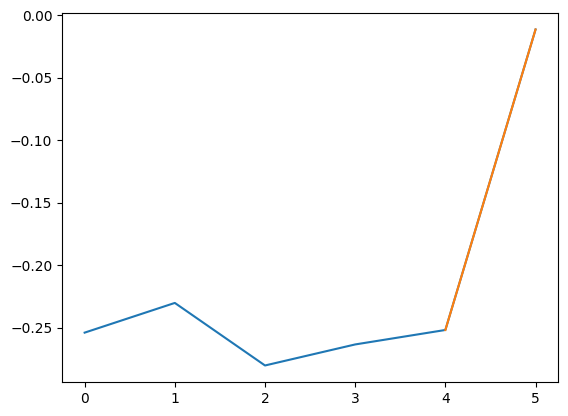

In [24]:

plt.plot(X[0, 0])
plt.plot(mapper[i].alignments[0].ravel(), mapper[i].mappings[0].ravel() )

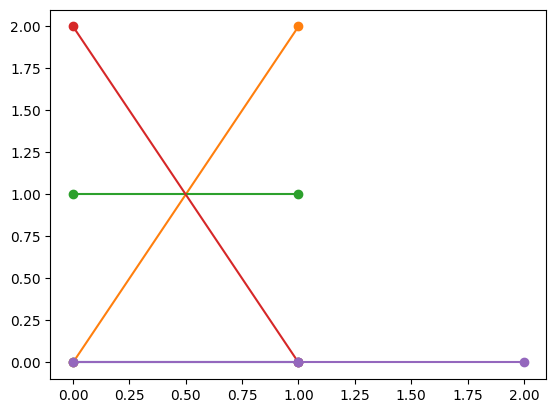

In [25]:
for i in range(5):
    plt.plot(mapper[i].word_array, marker="o")